In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

# 📥 1. Loading the Data

In [2]:
regime_features_df = pd.read_csv("../data/regime_features.csv").set_index('Date') # Contains not-scaled features, and regime data.
scaled_features_df = pd.read_csv("../data/scaled_features.csv").set_index('Date') # Constains scaled features, no regime data. used to train the K-Means model in notebook 01.
pca_components_df = pd.read_csv("../data/pca_components.csv") # Contains PC1, PC2, and regime data.

In [3]:
groups_names = ['Strong Bull', 'Panic', 'Stable Bull']

In [4]:
regime_features_df.index = pd.to_datetime(regime_features_df.index)
scaled_features_df.index = pd.to_datetime(scaled_features_df.index)
dates = regime_features_df.index

In [5]:
cumulative_logs = pd.DataFrame(regime_features_df['^GSPC'].cumsum())

# 🌲 2. Global Data Anomaly Detection - Isolation Forest
At this stage, we will perform anomaly detection on the entire dataset, without distinguishing between market regimes.  
The goal is to identify globally anomalous events, without taking into account the specific market regime at a given point in time.  
To achieve this, we will use the **IsolationForest** algorithm.   
> We use **10,000** trees in the IsolationForest to improve the robustness and stability of anomaly detection.   
> On lower-spec machines, such a high number may significantly increase runtime.  
In such cases, reducing the number of trees to 500–2000 is recommended, depending on performance constraints.

In [6]:
iso_for = IsolationForest(n_estimators=10_000,
                         n_jobs=-1,
                         random_state=999)

In [7]:
iso_for.fit(scaled_features_df)

IsolationForest(n_estimators=10000, n_jobs=-1, random_state=999)

In [8]:
iso_pred = iso_for.predict(scaled_features_df)

In [9]:
anomaly_regime_features_df = regime_features_df.copy()
anomaly_regime_features_df['anomaly'] = iso_pred

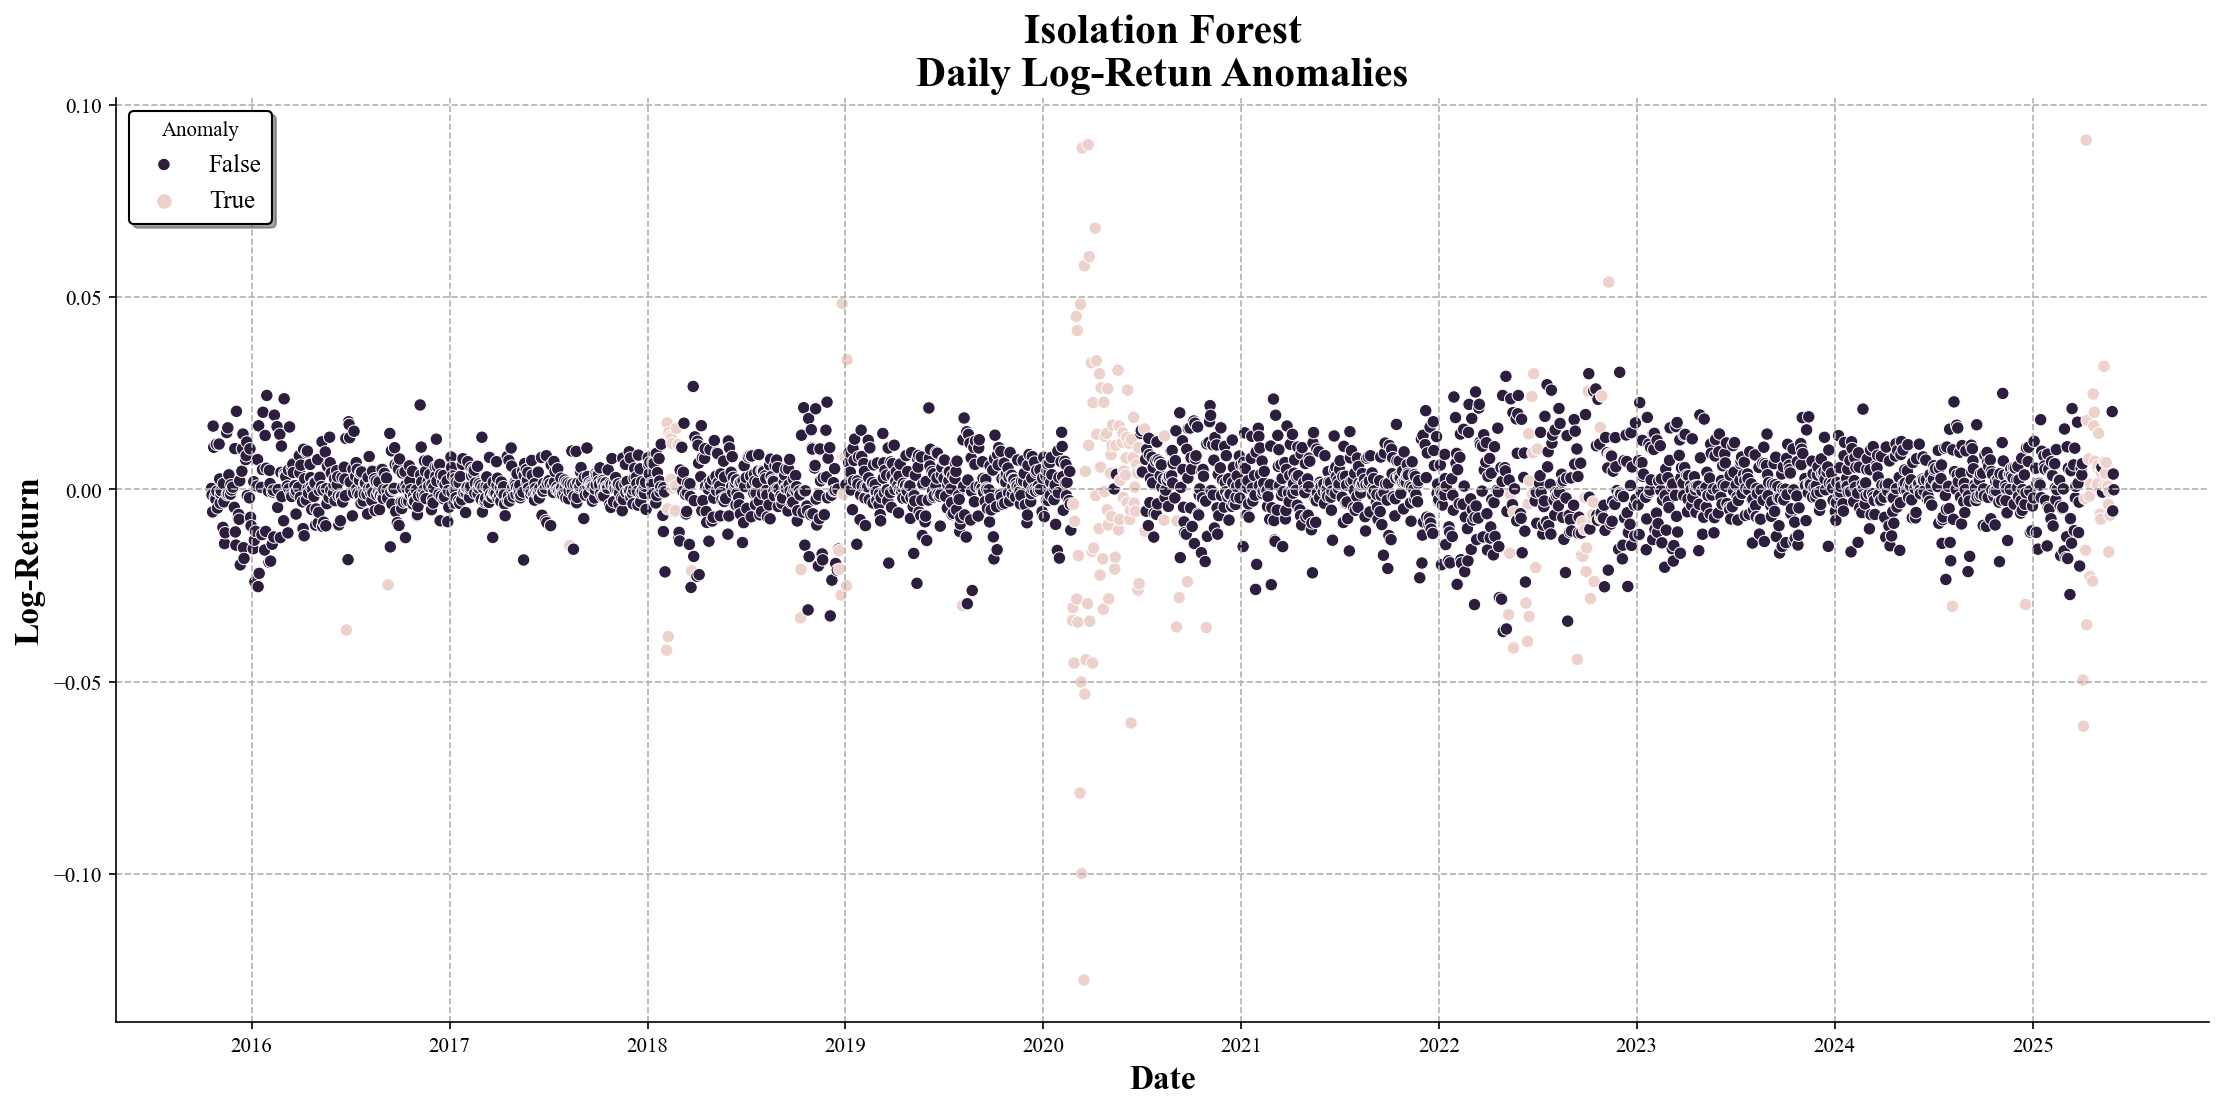

In [10]:
plt.figure(figsize=(18,8), dpi=150)
sns.scatterplot(anomaly_regime_features_df,
                x=dates,
                y='^GSPC',
                hue='anomaly',
               )

plt.xlabel('Date', size=16, weight='bold')
plt.ylabel('Log-Return', size=16, weight='bold')
plt.title('Isolation Forest\nDaily Log-Retun Anomalies', size=20, weight='bold')

plt.grid(ls='--')
plt.legend(['False', 'True'], title='Anomaly', 
          edgecolor='k', shadow=True,
          prop={'size': 12})
sns.despine()
plt.show()

In [11]:
cumulative_logs['anomaly'] = anomaly_regime_features_df['anomaly'].values

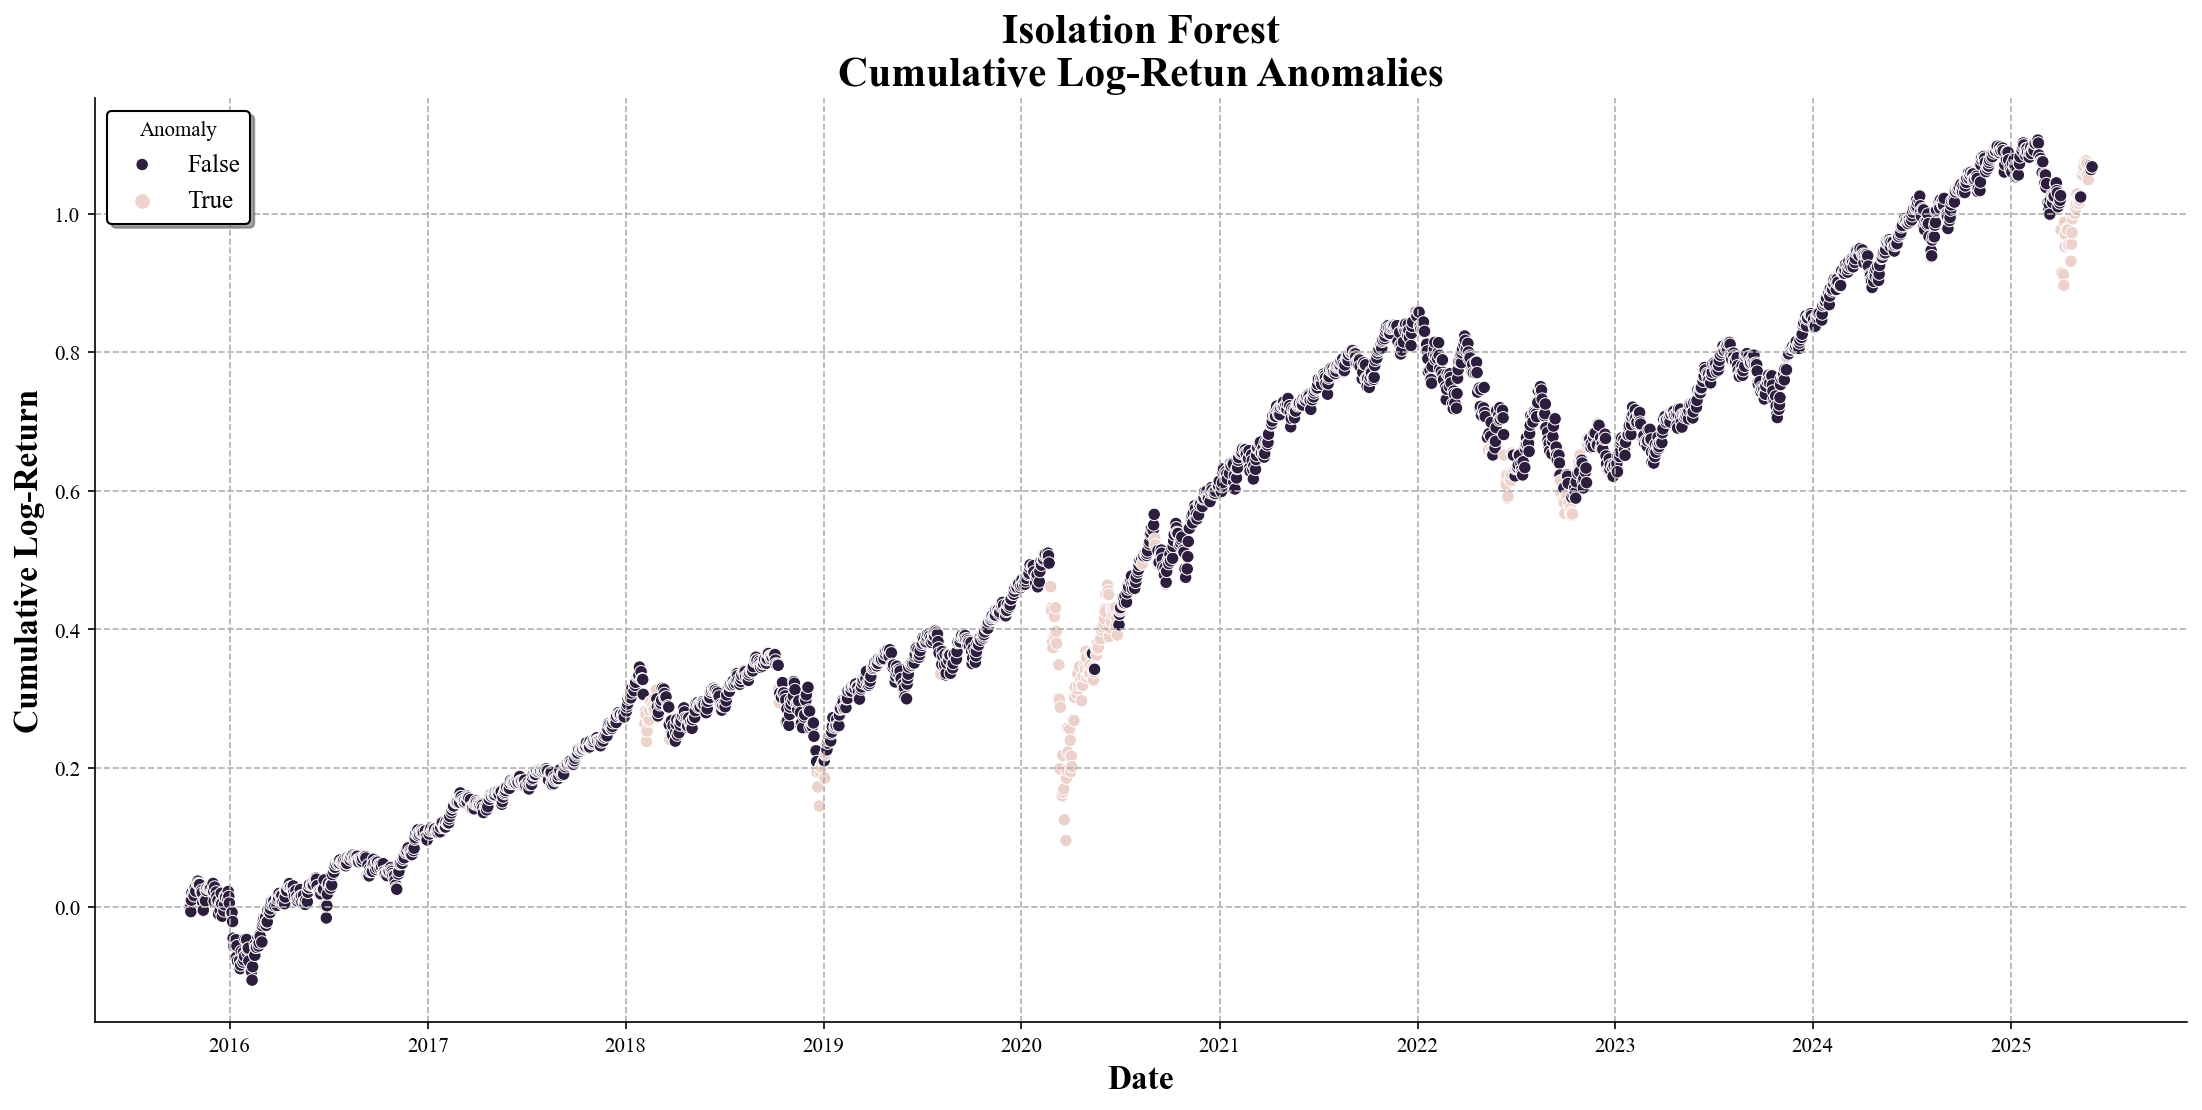

In [12]:
plt.figure(figsize=(18,8), dpi=150)
sns.scatterplot(cumulative_logs,
                x=cumulative_logs.index,
                y='^GSPC',
               hue='anomaly')
plt.xlabel('Date', size=16, weight='bold')
plt.ylabel('Cumulative Log-Return', size=16, weight='bold')
plt.title('Isolation Forest\nCumulative Log-Retun Anomalies', size=20, weight='bold')

plt.grid(ls='--')
plt.legend(['False', 'True'], title='Anomaly', 
          edgecolor='k', shadow=True,
          prop={'size': 12})
sns.despine()
plt.show()

# 🗜 3. Cluster-level Anomaly Detection
At this stage, we will perform anomaly detection within each market regime individually.  
The anomaly analysis will be divided into two types:

1. **Local anomaly detection**:  
   We use the **LocalOutlierFactor (LOF)** algorithm to identify anomalies based on nearest neighbors.

2. **Global anomaly detection**:  
   We apply **IsolationForest** again, this time separately on each market regime, in order to detect global anomalies within each group.  
    Since the groups are smaller and the algorithm must be run three times (once per regime), we use **2,000 decision trees** per group to balance performance and accuracy.

In [13]:
scaled_features_df['cluster'] = regime_features_df['cluster']
groups = scaled_features_df.groupby('cluster')

## 📍 3.1. Local Detection (```LocalOutlierFactor```)

In [14]:
def train_lof_groups(groupby_object, n_neighbors):
    """
    Applies Local Outlier Factor (LOF) to each group in the dataset.

    For each group, the function fits the LOF model and returns whether each point is an inlier or an outlier.

    Returns a dictionary with group names as keys and prediction arrays as values.
    """
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)
    results = {}
    for name, group in groupby_object:
        print(f'Fitting Group Number {name}')
        pred = lof.fit_predict(group)
        results[name] = pred
    return results

In [15]:
groups_local_anomalies = train_lof_groups(groups, 30)

Fitting Group Number 0
Fitting Group Number 1
Fitting Group Number 2


In [16]:
updated_local_groups = {}

for i, (name, group) in enumerate(groups):
    group = group.copy()
    group['local_anomaly'] = groups_local_anomalies[i]
    updated_local_groups[name] = group

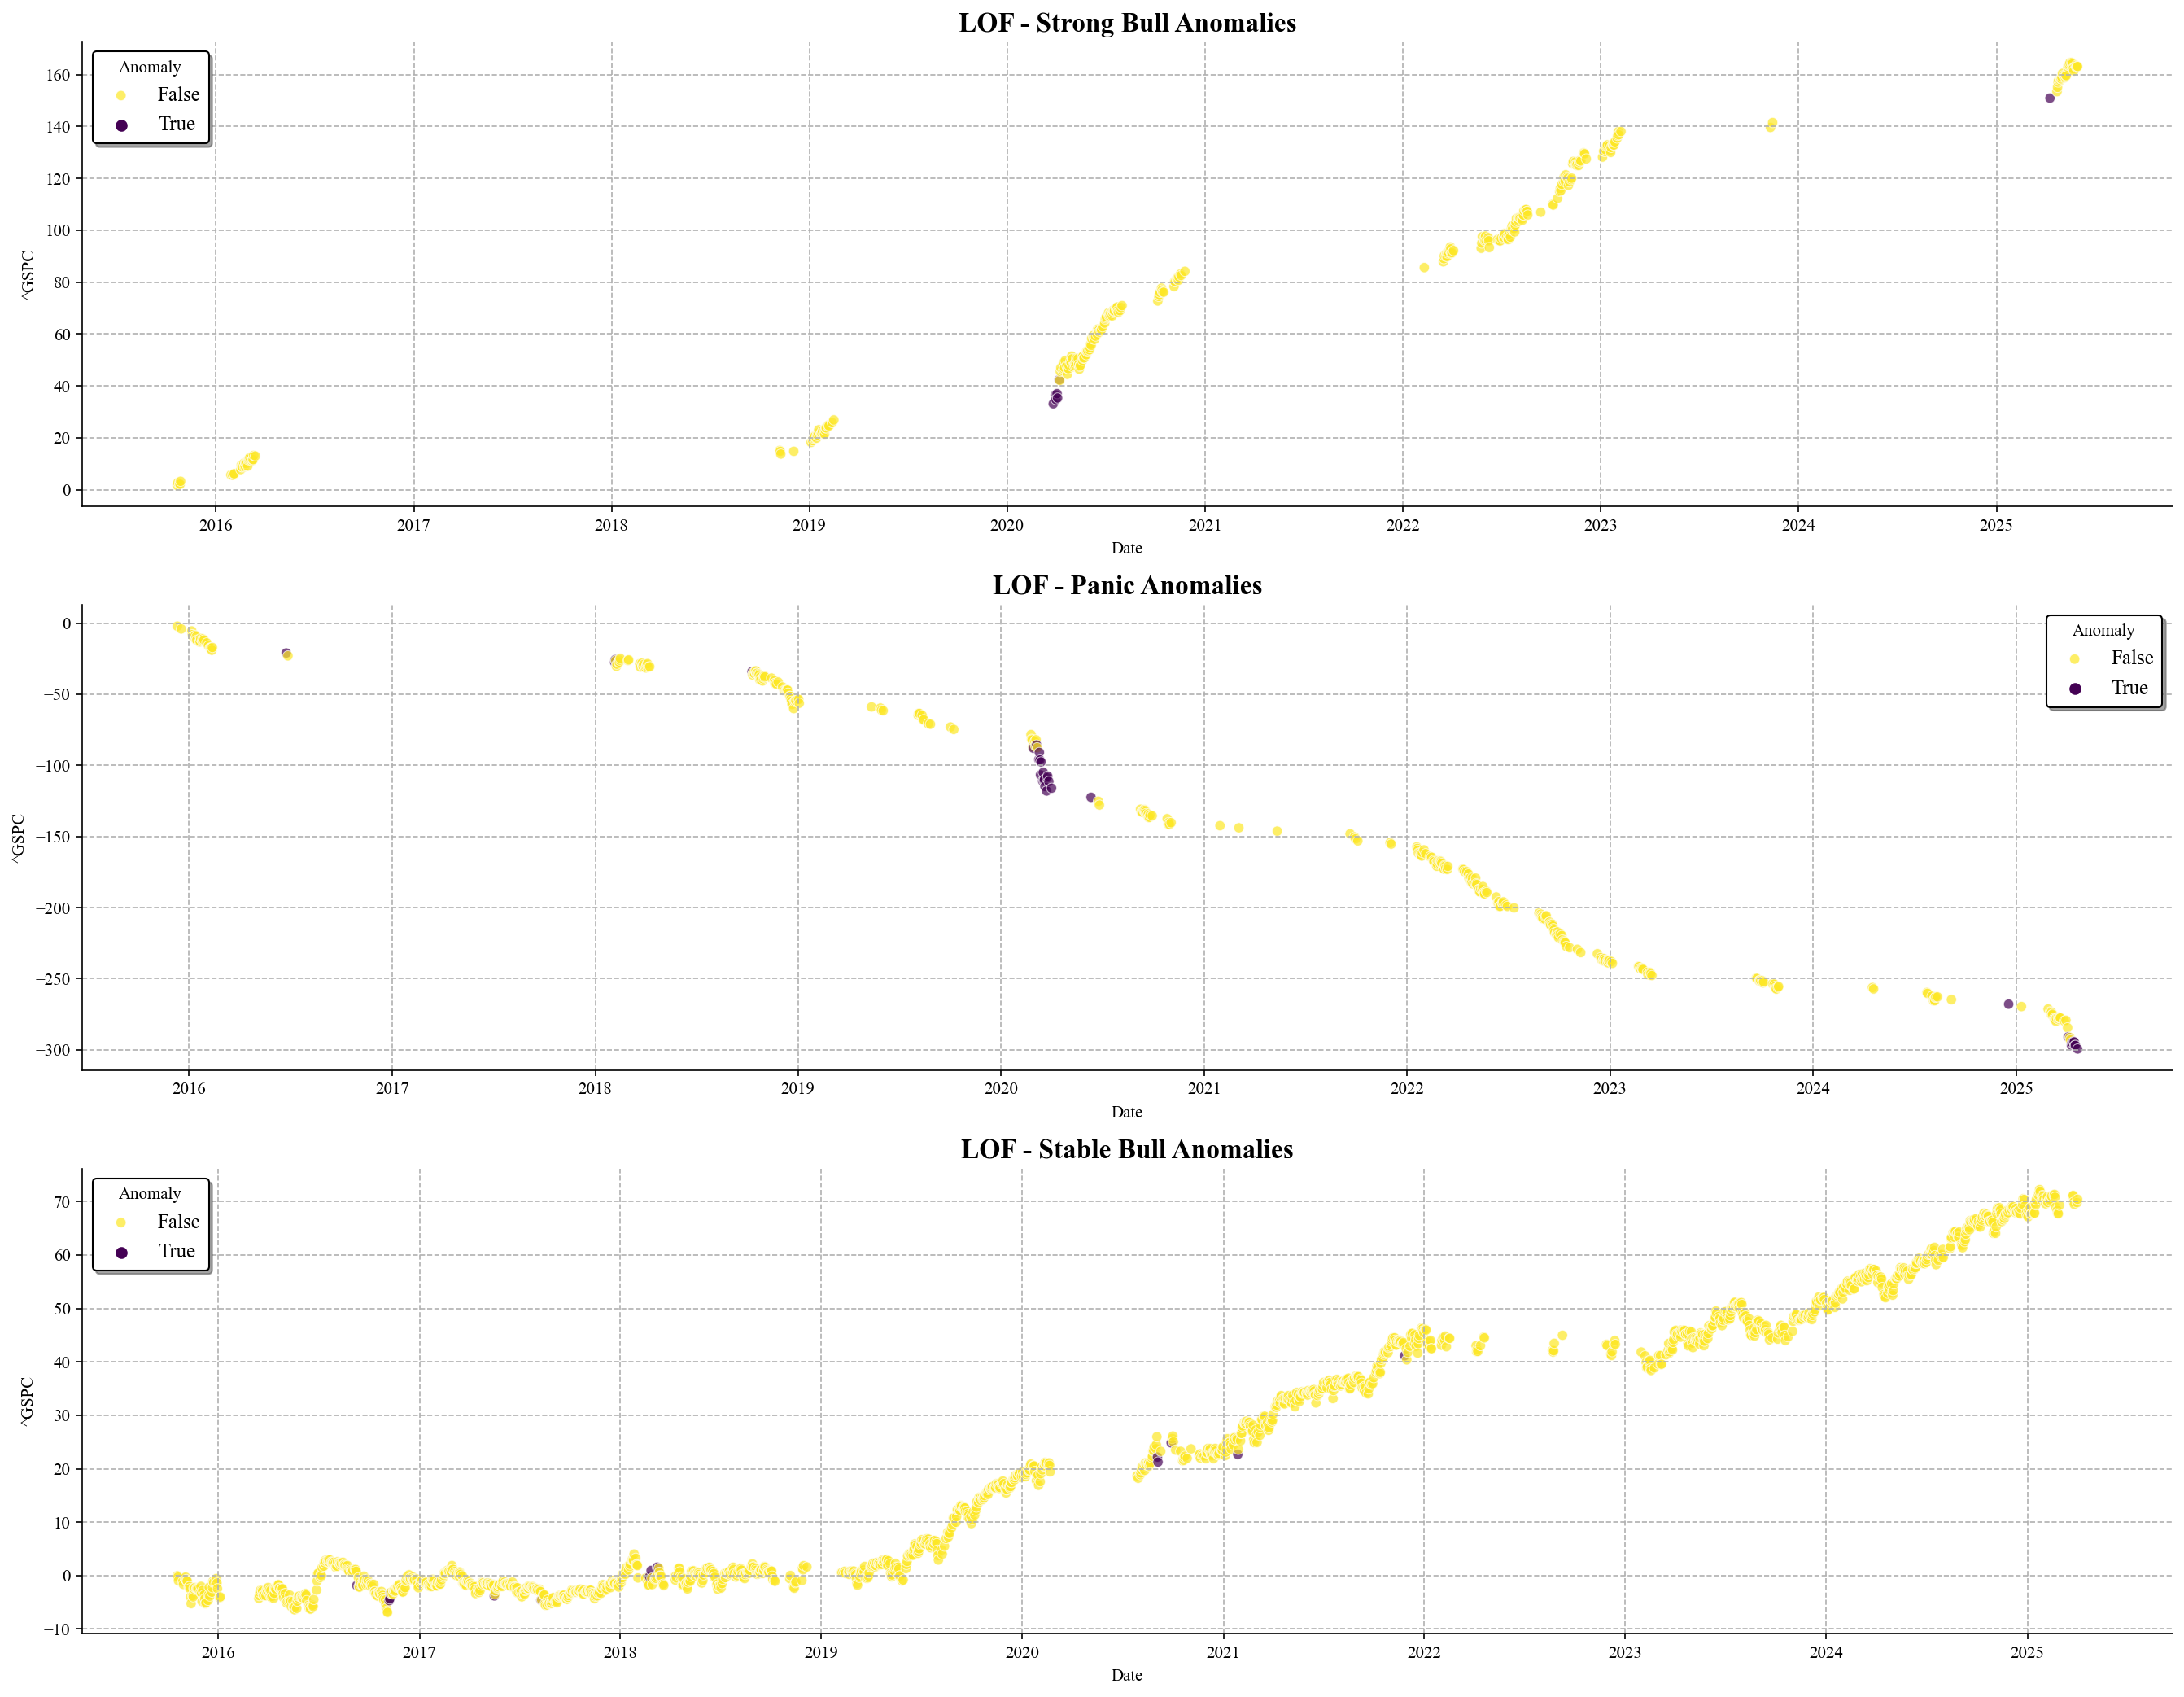

In [17]:
fig, ax = plt.subplots(3, 1, figsize=(18,14), dpi=150)

for i, (key, values) in enumerate(updated_local_groups.items()):
    g = updated_local_groups[i]
    sns.scatterplot(data =g,
                    x=g.index,
                    y=g['^GSPC'].cumsum(),
                    hue=g['local_anomaly'],
                    alpha=.7,
                    ax=ax[i],
                   palette='viridis')
    ax[i].set_title(f'LOF - {groups_names[i]} Anomalies', size=16, weight='bold')
    ax[i].grid(ls='--')
    ax[i].legend(['False', 'True'], title='Anomaly', 
                          edgecolor='k', shadow=True,
                          prop={'size': 12})

sns.despine()
plt.tight_layout()
plt.show()

## 🌐 3.2. Global Detection (```IsolationForest```)

In [18]:
def fit_isolationforest(groupby_object, n_estimators=2000):
    """
    Applies Isolation Forest to each group in the dataset.

    For each group, the function fits the model and returns whether each point is an inlier or an outlier.

    Returns a dictionary with group names as keys and prediction arrays as values.
    """
    iso = IsolationForest(n_estimators=n_estimators)
    results = {}
    for name, group in groupby_object:
        print(f'Fitting Group Number {name}')
        pred = iso.fit_predict(group)
        results[name] = pred
    return results

In [19]:
global_anomalies = fit_isolationforest(groups)

Fitting Group Number 0
Fitting Group Number 1
Fitting Group Number 2


In [20]:
updated_global_groups = {}

for i, (name, group) in enumerate(groups):
    group = group.copy()
    group['global_anomaly'] = global_anomalies[i]
    updated_global_groups[name] = group

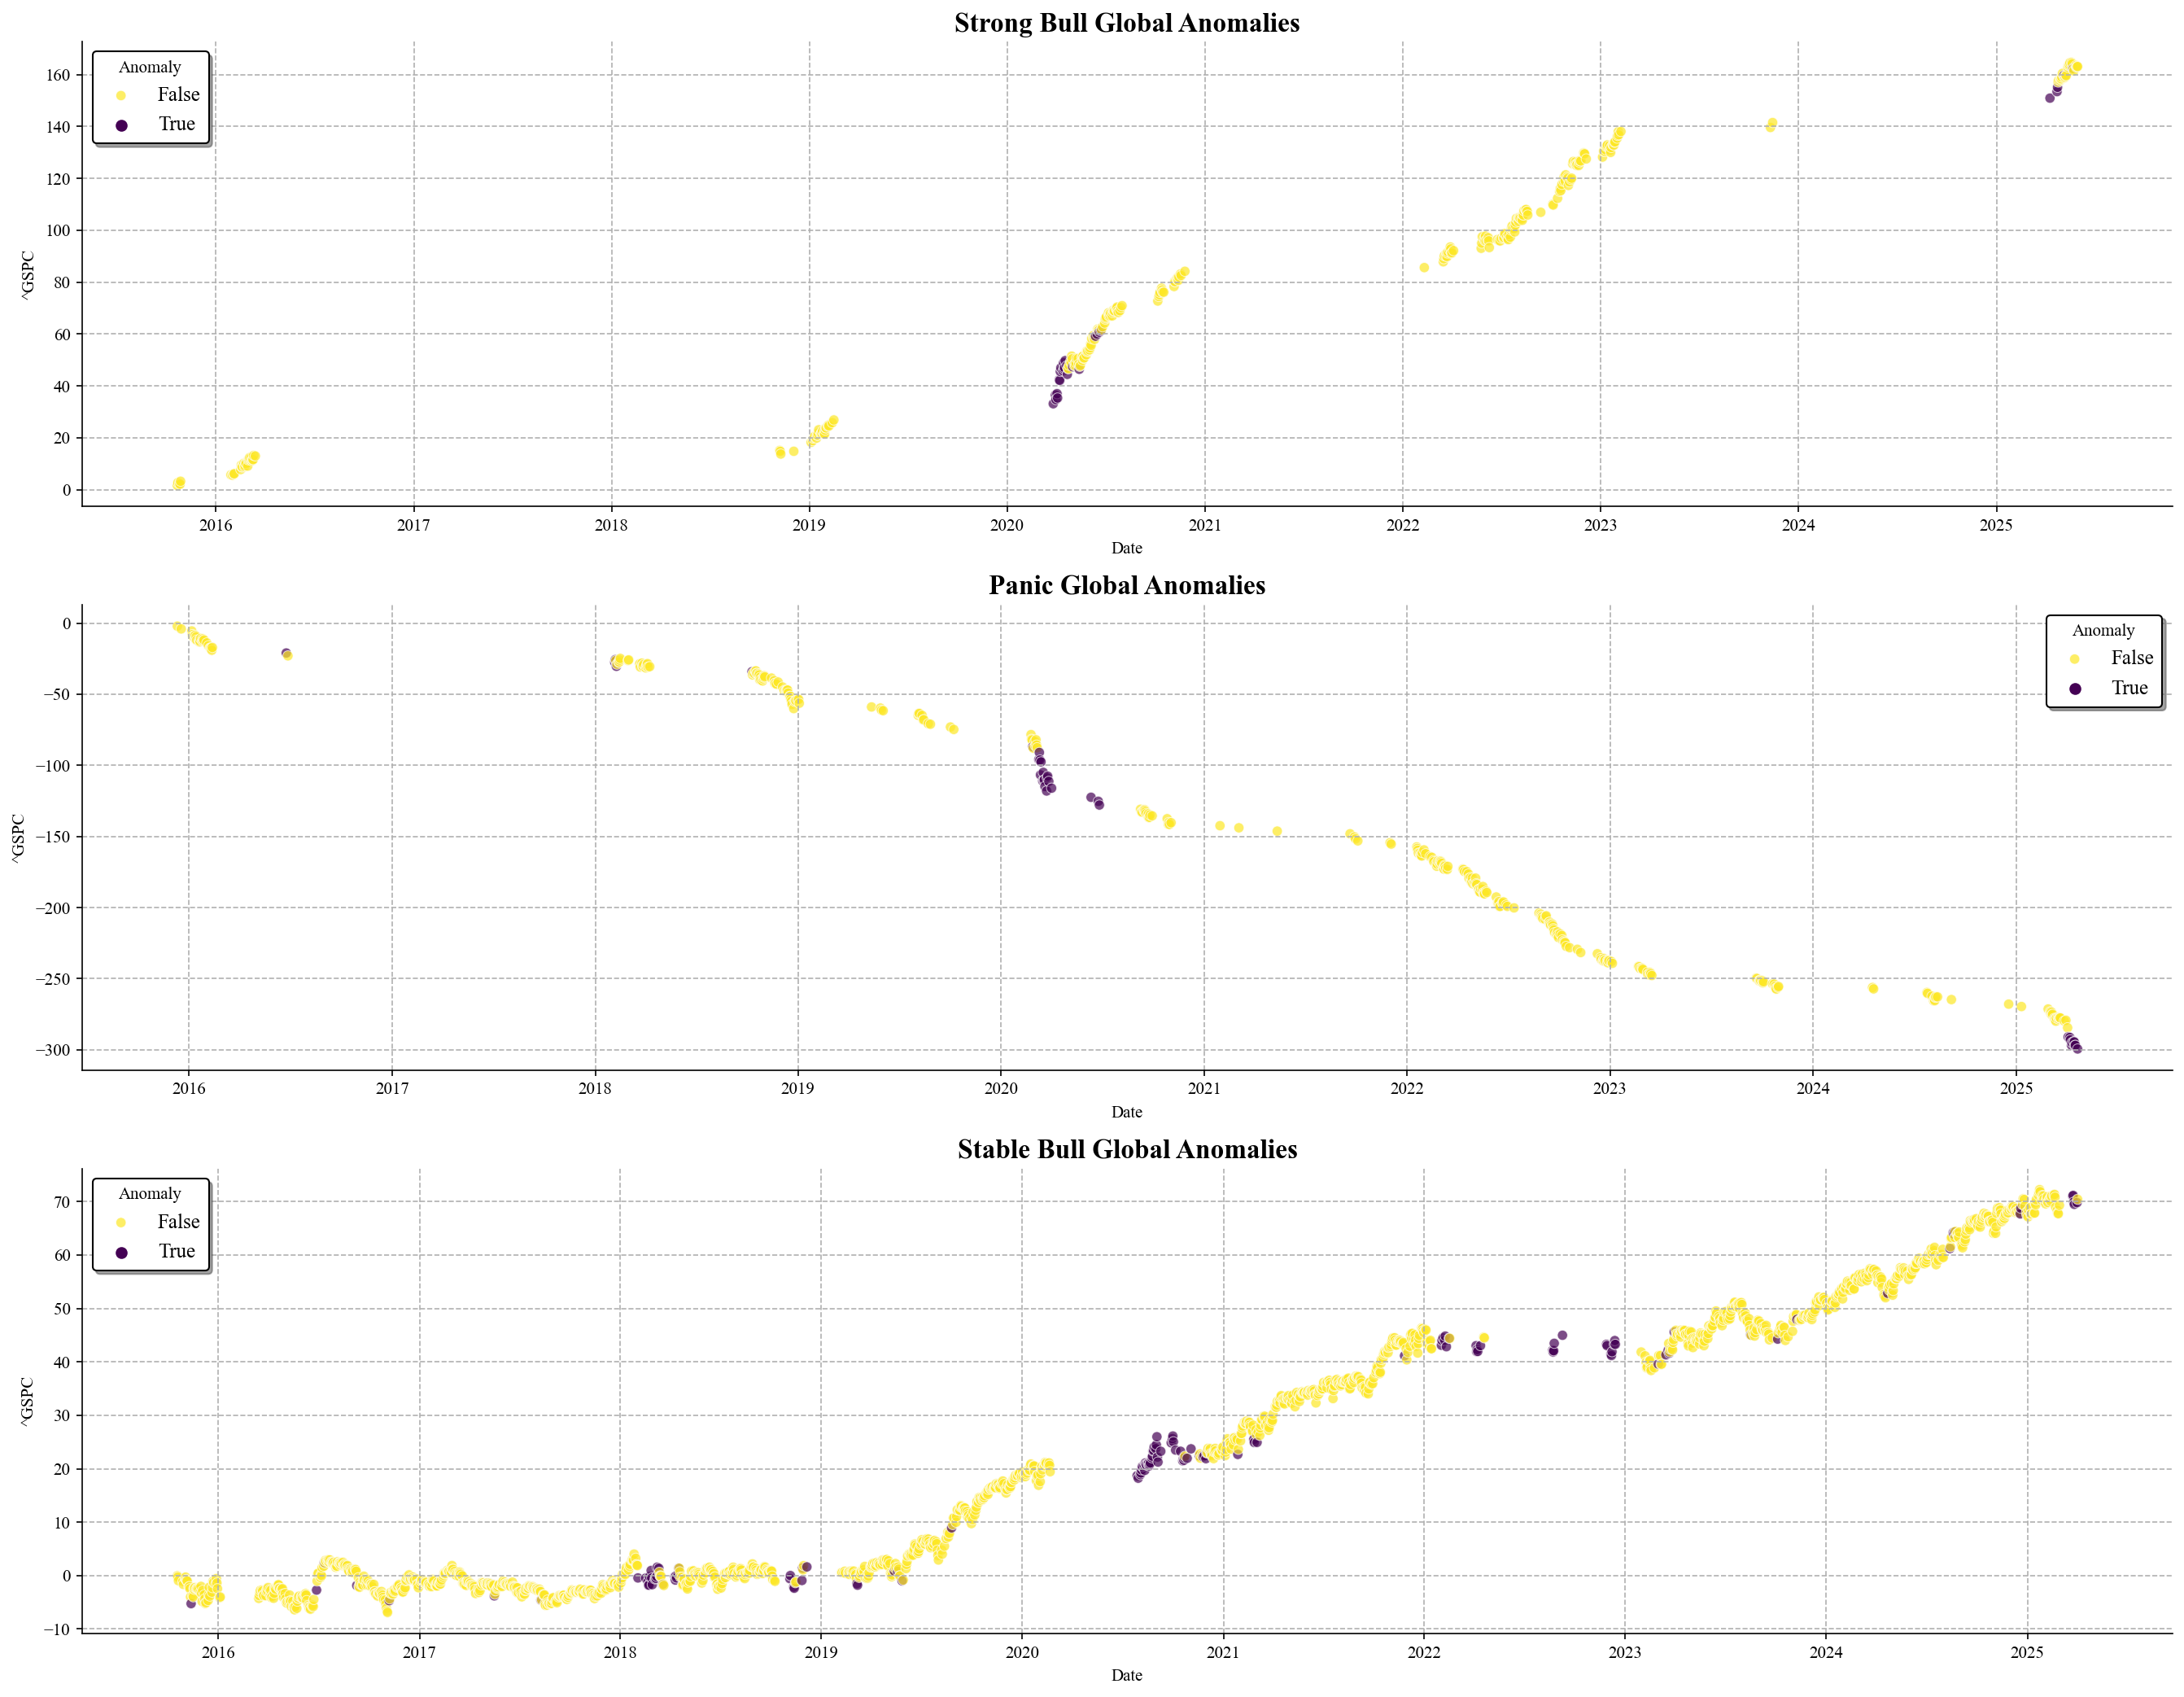

In [21]:
fig, ax = plt.subplots(3, 1, figsize=(18,14), dpi=150)

for i, (key, values) in enumerate(updated_global_groups.items()):
    g = updated_global_groups[i]
    sns.scatterplot(data =g,
                    x=g.index,
                    y=g['^GSPC'].cumsum(),
                    hue=g['global_anomaly'],
                    alpha=.7,
                    ax=ax[i],
                   palette='viridis')
    ax[i].set_title(f'{groups_names[i]} Global Anomalies', size=16, weight='bold')
    ax[i].grid(ls='--')
    ax[i].legend(['False', 'True'], title='Anomaly', 
                          edgecolor='k', shadow=True,
                          prop={'size': 12})

sns.despine()
plt.tight_layout()
plt.show()

# ↔️↕️ 4. Cluster-level PCA
At this stage, we perform Principal Component Analysis (PCA) separately for each cluster.  
For each analysis, we generate two visualizations:  
one focusing on local anomalies and another focusing on global anomalies.  
This allows us to visually compare the performance of the algorithms and characterize the severity of the outliers.

In [22]:
def groups_pca(groupby_object):
    """
    Applies 2-component PCA to each group in the dataset.

    For each group, the function fits PCA and returns a DataFrame with the first two principal components.

    Returns a dictionary with group indices as keys and 2D PCA DataFrames as values.
    """
    results = {}
    pca = PCA(2)
    for i, (name, group) in enumerate(groupby_object):
        print(f'Fitting Group Number {name}')
        principal_components = pca.fit_transform(group)
        df = pd.DataFrame(data=principal_components,
                         columns=['PC1', 'PC2'])
        results[i] = df
    return results

In [23]:
groups_principal_components = groups_pca(groups)

Fitting Group Number 0
Fitting Group Number 1
Fitting Group Number 2


In [24]:
for i in range(len(groups_principal_components)):
    groups_principal_components[i]['global_anomaly'] = global_anomalies[i]
    groups_principal_components[i]['local_anomaly'] = groups_local_anomalies[i]

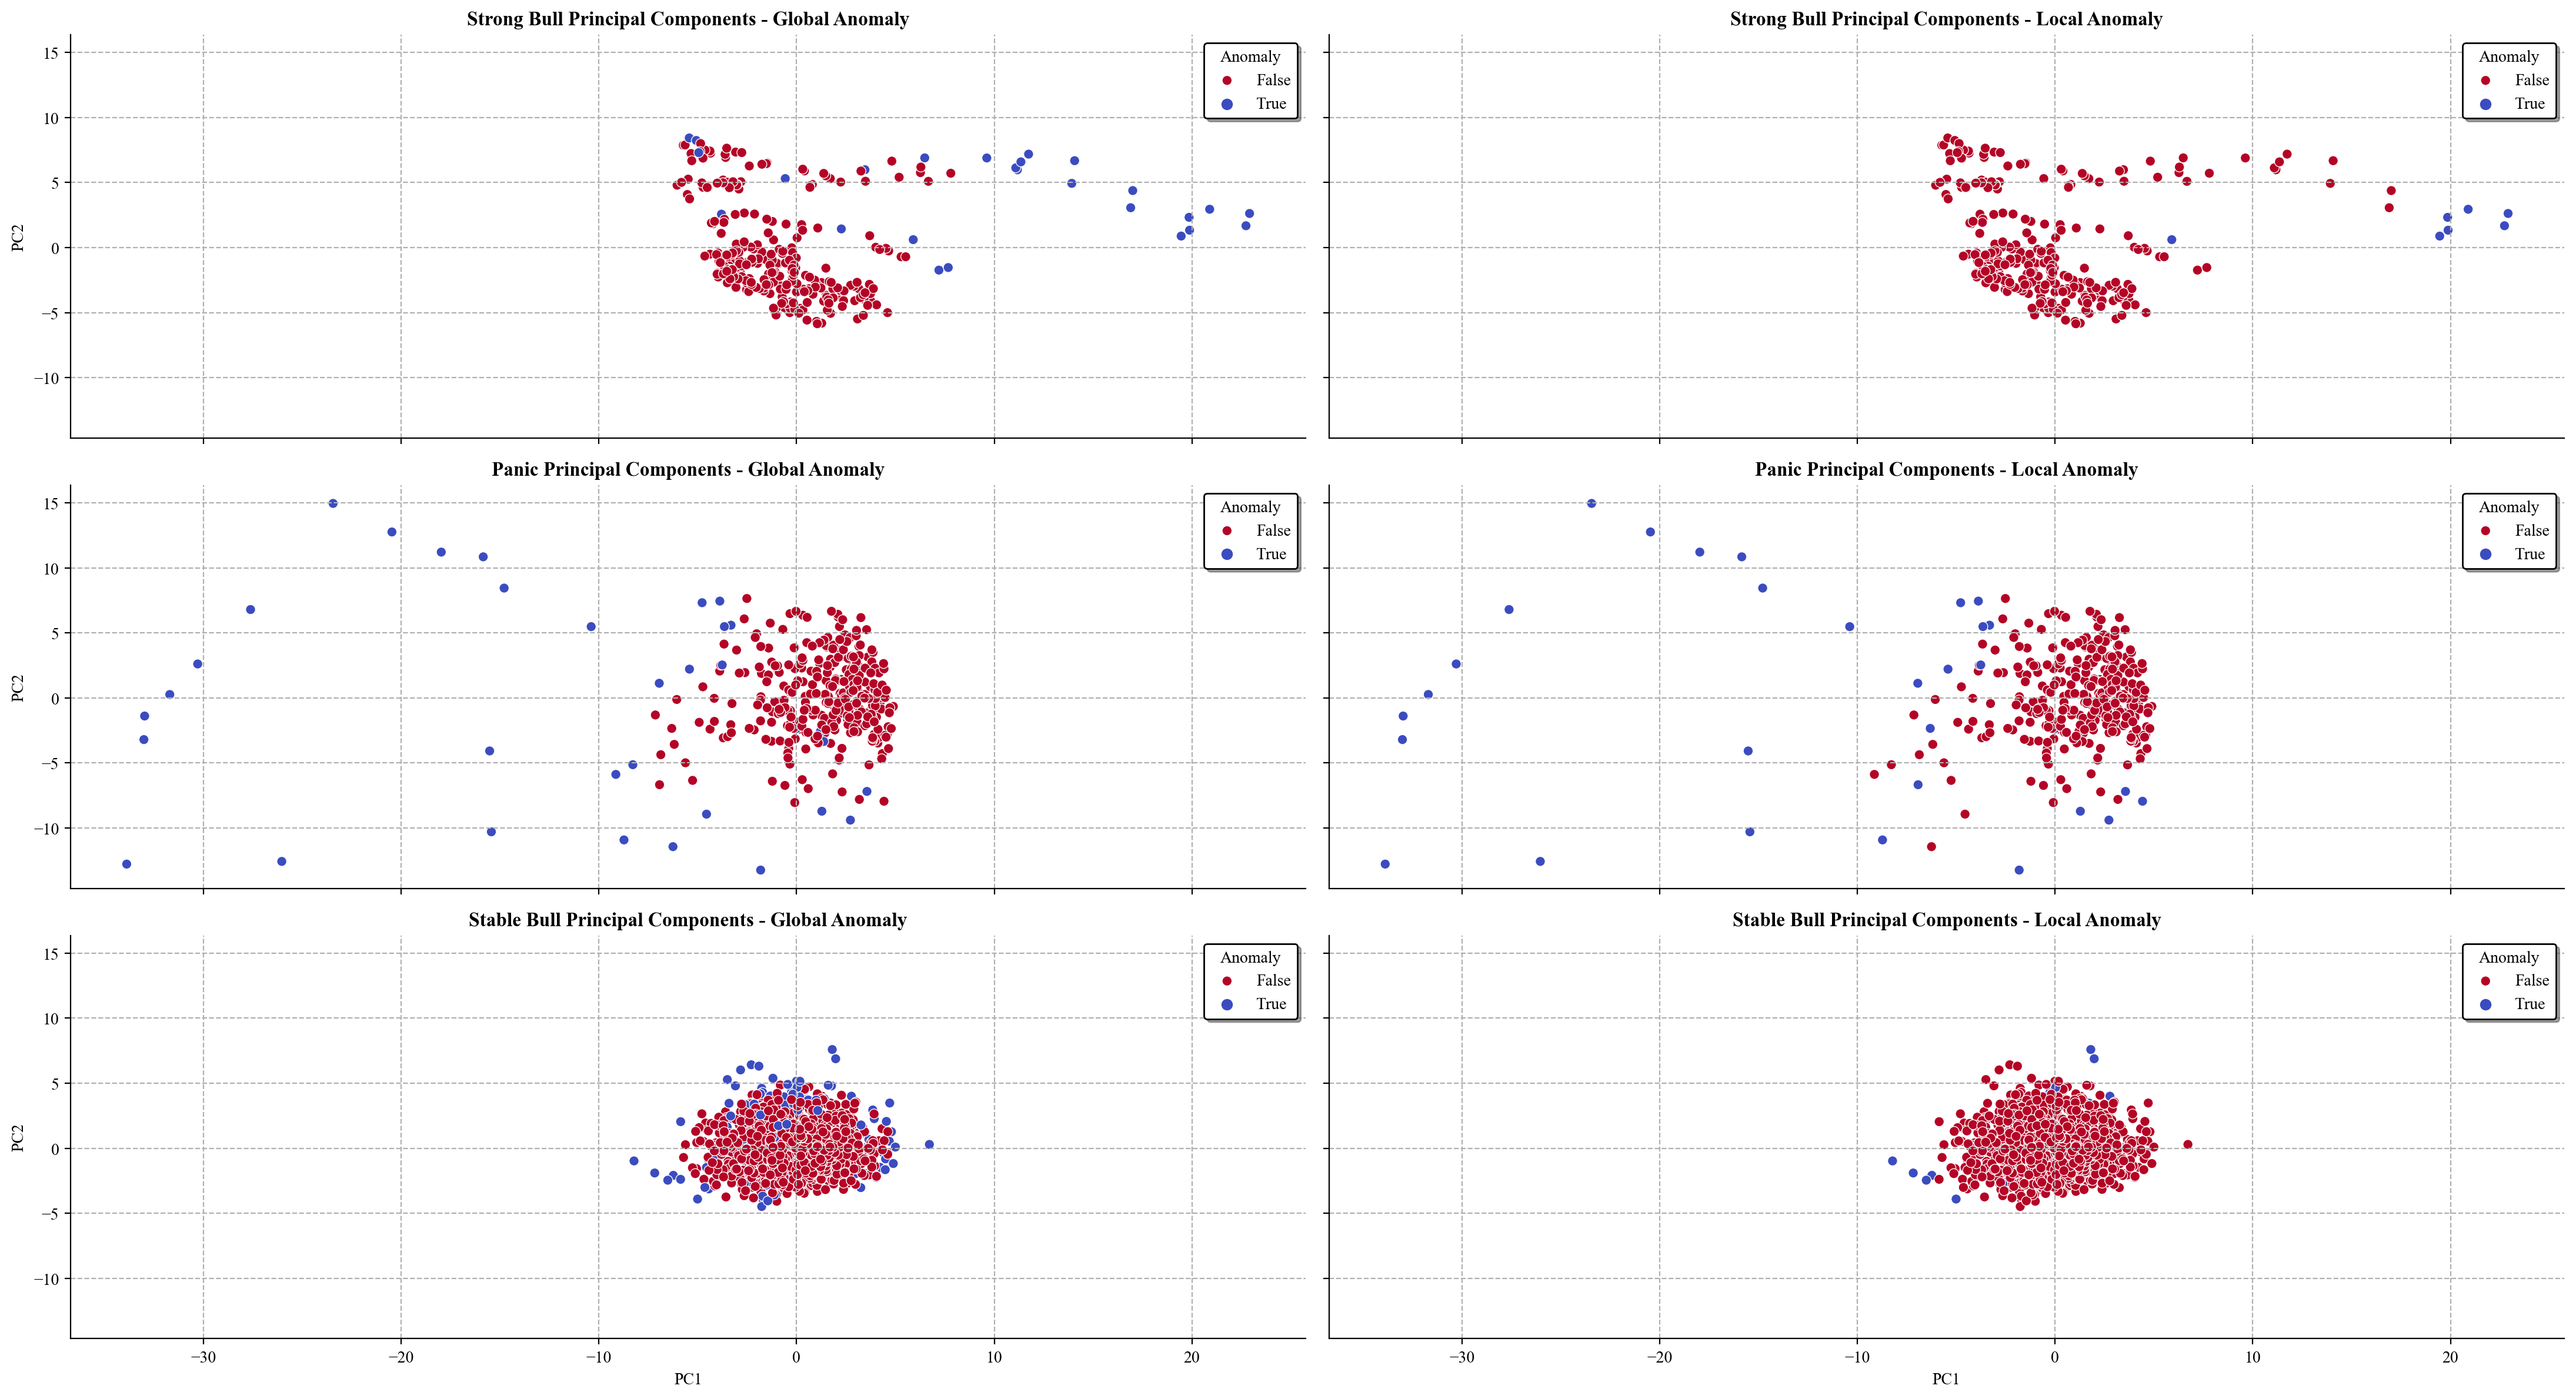

In [25]:
fig, ax = plt.subplots(3,2, figsize=(22, 12), sharex=True, sharey=True, dpi=200)

for i in range(len(groups_principal_components)):
    df = groups_principal_components[i]
    
    sns.scatterplot(data=df, x='PC1', y='PC2', hue='global_anomaly',
                    ax=ax[i, 0], palette='coolwarm', legend=True)
    ax[i,0].set_title(f'{groups_names[i]} Principal Components - Global Anomaly', weight='bold')
    ax[i,0].grid(ls='--')
    ax[i,0].legend(['False', 'True'], title='Anomaly',
                  edgecolor='k', shadow=1)
    
    sns.scatterplot(data=df, x='PC1', y='PC2', hue='local_anomaly',
                    ax=ax[i, 1], palette='coolwarm', legend=True)
    ax[i,1].set_title(f'{groups_names[i]} Principal Components - Local Anomaly', weight='bold')
    ax[i,1].grid(ls='--')
    ax[i,1].legend(['False', 'True'], title='Anomaly',
                  edgecolor='k', shadow=1)

sns.despine()
plt.tight_layout()
plt.show()

# 🔬 Anomaly Behavior Across Market Regimes

The anomaly analysis provides an additional perspective on the structure and nature of the identified clusters:

- **Cluster 0 (Stable Bull)** exhibits strong concentration near the origin in PCA space, reinforcing its **insensitivity to abrupt changes** in the underlying features.  
  Global anomalies appear more frequently than local ones, suggesting that deviations are only detectable from a broad distributional perspective, consistent with a **smooth, trend-following regime**.

- **Cluster 1 (Panic)** shows wide dispersion across both principal components and **high overlap between local and global anomalies**, indicating **random, chaotic behavior** and sensitivity to both micro- and macro-level deviations.

- **Cluster 2 (Volatile Bull)** is spread across the PCA space in a direction roughly **opposite to the Panic cluster**, and features **more global than local anomalies**.  
  This pattern suggests that the regime reflects a blend of the other two: while it exhibits substantial variability and dispersion, it still retains some **underlying directional structure**, with **opposite behavior along PC1** compared to the Panic cluster.

Altogether, the anomaly profiles further validate the distinct nature of each regime, capturing not just their average behavior but also the stability (or fragility) of their internal structure.


In [26]:
# Create a copy of the original scaled features
scaled_features_intergroup_anomalies = scaled_features_df.copy()

# Combine anomaly labels from the group-level dictionaries
global_anomalies_df = pd.concat(updated_global_groups.values())
local_anomalies_df = pd.concat(updated_local_groups.values())

# Add anomaly labels as new columns
scaled_features_intergroup_anomalies['cluster_global_anomaly'] = (
    scaled_features_intergroup_anomalies.index.map(global_anomalies_df['global_anomaly'])
)
scaled_features_intergroup_anomalies['cluster_local_anomaly'] = (
    scaled_features_intergroup_anomalies.index.map(local_anomalies_df['local_anomaly'])
)

# Handle missing values (e.g., for rows not included in any cluster)
scaled_features_intergroup_anomalies[['cluster_global_anomaly', 'cluster_local_anomaly']] = (
    scaled_features_intergroup_anomalies[['cluster_global_anomaly', 'cluster_local_anomaly']]
    .fillna(0)  # or fillna(-1) depending on your convention
    .astype(int)
)

In [27]:
scaled_features_intergroup_anomalies['general_global_anomaly'] = iso_pred

In [28]:
scaled_features_intergroup_anomalies.to_csv('../data/scaled_features_anomalies_data.csv')